## Задание 5.1

Набор данных тут: https://github.com/sismetanin/rureviews, также есть в папке [Data](https://drive.google.com/drive/folders/1YAMe7MiTxA-RSSd8Ex2p-L0Dspe6Gs4L). Те, кто предпочитает работать с английским языком, могут использовать набор данных `sms_spam`.

Применим полученные навыки и решим задачу анализа тональности отзывов. 

Нужно повторить весь пайплайн от сырых текстов до получения обученной модели.

Обязательные шаги предобработки:
1. приведение к нижнему регистру
2. токенизация
3. удаление стоп-слов
4. лемматизация
5. векторизация (с настройкой гиперпараметров)
6. построение модели
7. оценка качества модели

Обязательно использование векторайзеров:
1. мешок n-грамм (диапазон для n подбирайте самостоятельно, запрещено использовать только униграммы).
2. tf-idf ((диапазон для n подбирайте самостоятельно, также нужно подбирать гиперпараметры max_df, min_df, max_features)
3. символьные n-граммы (диапазон для n подбирайте самостоятельно)

В качестве классификатора нужно использовать наивный байесовский классификатор. 

Для сравнения векторайзеров между собой используйте precision, recall, f1-score и accuracy. Для этого сформируйте датафрейм, в котором в строках будут разные векторайзеры, а в столбцах разные метрики качества, а в  ячейках будут значения этих метрик для соответсвующих векторайзеров.

### 0) Загрузка и подготовка данных

In [ ]:
import nltk
import pandas as pd
import string
import numpy as np
import warnings
import matplotlib.pyplot as plt

from nltk.corpus import stopwords, wordnet
from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.naive_bayes import MultinomialNB

warnings.filterwarnings('ignore')
nltk.download("stopwords", quiet=True)
nltk.download("punkt", quiet=True)
nltk.download("wordnet", quiet=True)
nltk.download("omw-1.4", quiet=True)
nltk.download('averaged_perceptron_tagger', quiet=True)
pd.set_option('max_colwidth', 400)
%matplotlib inline

In [ ]:
from google.colab import drive


drive.mount("/google_drive")

Mounted at /google_drive


In [ ]:
sms_spam = pd.read_csv("/google_drive/MyDrive/Data/sms_spam.csv", sep=",")
sms_spam

,type,text
0,ham,Hope you are having a good week. Just checking in
1,ham,K..give back my thanks.
2,ham,Am also doing in cbe only. But have to pay.
3,spam,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+"
4,spam,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm
...,...,...
5554,ham,You are a great role model. You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont. I've looked up to you since i was young and i still do. Have a great day.
5555,ham,"Awesome, I remember the last time we got somebody high for the first time with diesel :V"
5556,spam,"If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy"
5557,spam,"SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO"


#### 1. Изменим type на ±1

In [ ]:
sms_spam.replace({"type": {"ham": -1, "spam": 1}}, inplace=True)
sms_spam

,type,text
0,-1,Hope you are having a good week. Just checking in
1,-1,K..give back my thanks.
2,-1,Am also doing in cbe only. But have to pay.
3,1,"complimentary 4 STAR Ibiza Holiday or £10,000 cash needs your URGENT collection. 09066364349 NOW from Landline not to lose out! Box434SK38WP150PPM18+"
4,1,okmail: Dear Dave this is your final notice to collect your 4* Tenerife Holiday or #5000 CASH award! Call 09061743806 from landline. TCs SAE Box326 CW25WX 150ppm
...,...,...
5554,-1,You are a great role model. You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont. I've looked up to you since i was young and i still do. Have a great day.
5555,-1,"Awesome, I remember the last time we got somebody high for the first time with diesel :V"
5556,1,"If you don't, your prize will go to another customer. T&C at www.t-c.biz 18+ 150p/min Polo Ltd Suite 373 London W1J 6HL Please call back if busy"
5557,1,"SMS. ac JSco: Energy is high, but u may not know where 2channel it. 2day ur leadership skills r strong. Psychic? Reply ANS w/question. End? Reply END JSCO"


#### 2. Уберём знаки препинания

In [ ]:
print(string.punctuation)

sms_spam.text = sms_spam.text.str.replace(rf"[{string.punctuation}]", "", regex=True) 
sms_spam

!"#$%&'()*+,-./:;<=>?@[\]^_`{|}~


,type,text
0,-1,Hope you are having a good week Just checking in
1,-1,Kgive back my thanks
2,-1,Am also doing in cbe only But have to pay
3,1,complimentary 4 STAR Ibiza Holiday or £10000 cash needs your URGENT collection 09066364349 NOW from Landline not to lose out Box434SK38WP150PPM18
4,1,okmail Dear Dave this is your final notice to collect your 4 Tenerife Holiday or 5000 CASH award Call 09061743806 from landline TCs SAE Box326 CW25WX 150ppm
...,...,...
5554,-1,You are a great role model You are giving so much and i really wish each day for a miracle but God as a reason for everything and i must say i wish i knew why but i dont Ive looked up to you since i was young and i still do Have a great day
5555,-1,Awesome I remember the last time we got somebody high for the first time with diesel V
5556,1,If you dont your prize will go to another customer TC at wwwtcbiz 18 150pmin Polo Ltd Suite 373 London W1J 6HL Please call back if busy
5557,1,SMS ac JSco Energy is high but u may not know where 2channel it 2day ur leadership skills r strong Psychic Reply ANS wquestion End Reply END JSCO


### 1) Приведение к нижнему регистру

In [ ]:
sms_spam.text = sms_spam.text.str.lower()
sms_spam

,type,text
0,-1,hope you are having a good week just checking in
1,-1,kgive back my thanks
2,-1,am also doing in cbe only but have to pay
3,1,complimentary 4 star ibiza holiday or £10000 cash needs your urgent collection 09066364349 now from landline not to lose out box434sk38wp150ppm18
4,1,okmail dear dave this is your final notice to collect your 4 tenerife holiday or 5000 cash award call 09061743806 from landline tcs sae box326 cw25wx 150ppm
...,...,...
5554,-1,you are a great role model you are giving so much and i really wish each day for a miracle but god as a reason for everything and i must say i wish i knew why but i dont ive looked up to you since i was young and i still do have a great day
5555,-1,awesome i remember the last time we got somebody high for the first time with diesel v
5556,1,if you dont your prize will go to another customer tc at wwwtcbiz 18 150pmin polo ltd suite 373 london w1j 6hl please call back if busy
5557,1,sms ac jsco energy is high but u may not know where 2channel it 2day ur leadership skills r strong psychic reply ans wquestion end reply end jsco


### 2) Удаление стоп-слов

In [ ]:
noise = stopwords.words("english")
print(*noise[:10])

sms_spam.text = sms_spam.text.apply(lambda x: " ".join([word for word in x.split() if word not in noise]))
sms_spam

i me my myself we our ours ourselves you you're


,type,text
0,-1,hope good week checking
1,-1,kgive back thanks
2,-1,also cbe pay
3,1,complimentary 4 star ibiza holiday £10000 cash needs urgent collection 09066364349 landline lose box434sk38wp150ppm18
4,1,okmail dear dave final notice collect 4 tenerife holiday 5000 cash award call 09061743806 landline tcs sae box326 cw25wx 150ppm
...,...,...
5554,-1,great role model giving much really wish day miracle god reason everything must say wish knew dont ive looked since young still great day
5555,-1,awesome remember last time got somebody high first time diesel v
5556,1,dont prize go another customer tc wwwtcbiz 18 150pmin polo ltd suite 373 london w1j 6hl please call back busy
5557,1,sms ac jsco energy high u may know 2channel 2day ur leadership skills r strong psychic reply ans wquestion end reply end jsco


### 3) Токенизация

In [ ]:
sms_spam.text = sms_spam.text.apply(word_tokenize)
sms_spam

,type,text
0,-1,"[hope, good, week, checking]"
1,-1,"[kgive, back, thanks]"
2,-1,"[also, cbe, pay]"
3,1,"[complimentary, 4, star, ibiza, holiday, £10000, cash, needs, urgent, collection, 09066364349, landline, lose, box434sk38wp150ppm18]"
4,1,"[okmail, dear, dave, final, notice, collect, 4, tenerife, holiday, 5000, cash, award, call, 09061743806, landline, tcs, sae, box326, cw25wx, 150ppm]"
...,...,...
5554,-1,"[great, role, model, giving, much, really, wish, day, miracle, god, reason, everything, must, say, wish, knew, dont, ive, looked, since, young, still, great, day]"
5555,-1,"[awesome, remember, last, time, got, somebody, high, first, time, diesel, v]"
5556,1,"[dont, prize, go, another, customer, tc, wwwtcbiz, 18, 150pmin, polo, ltd, suite, 373, london, w1j, 6hl, please, call, back, busy]"
5557,1,"[sms, ac, jsco, energy, high, u, may, know, 2channel, 2day, ur, leadership, skills, r, strong, psychic, reply, ans, wquestion, end, reply, end, jsco]"


### 4) Лемматизация

In [ ]:
lemmatizer = WordNetLemmatizer()

def get_pos(word):
    tag = nltk.pos_tag([word])[0][1][0].upper()
    tag_dict = {"J": wordnet.ADJ,
                "N": wordnet.NOUN,
                "V": wordnet.VERB,
                "R": wordnet.ADV}

    return tag_dict.get(tag, wordnet.NOUN)

sms_spam.text = sms_spam.text.apply(lambda x: " ".join([lemmatizer.lemmatize(word, get_pos(word)) for word in x]))
sms_spam

,type,text
0,-1,hope good week check
1,-1,kgive back thanks
2,-1,also cbe pay
3,1,complimentary 4 star ibiza holiday £10000 cash need urgent collection 09066364349 landline lose box434sk38wp150ppm18
4,1,okmail dear dave final notice collect 4 tenerife holiday 5000 cash award call 09061743806 landline tc sae box326 cw25wx 150ppm
...,...,...
5554,-1,great role model give much really wish day miracle god reason everything must say wish knew dont ive look since young still great day
5555,-1,awesome remember last time get somebody high first time diesel v
5556,1,dont prize go another customer tc wwwtcbiz 18 150pmin polo ltd suite 373 london w1j 6hl please call back busy
5557,1,sm ac jsco energy high u may know 2channel 2day ur leadership skill r strong psychic reply an wquestion end reply end jsco


### 5-7) Векторизация, Построение модели, Оценка Точности

In [ ]:
def create_x_ticks(df_index: pd.MultiIndex):
    return [f"{item[0].replace(" ", "\n")}\nclass={item[1]}\nsupport={item[2]}" for item in df_index]

sms_spam_prepared = sms_spam.copy(deep=True)
x_train, x_test, y_train, y_test = train_test_split(sms_spam_prepared.text,
                                                    sms_spam_prepared.type,
                                                    train_size=0.7)

model = MultinomialNB()

#### 1. Мешок слов (n-грамм)

In [ ]:
ngram_max_size = 16
ngram_ranges = [(i, j) for i in range(1, ngram_max_size) for j in range(i, ngram_max_size)]
df_result_ngram = pd.DataFrame()
for ngram_range in ngram_ranges:
    # Векторизация
    ngram_vectorizer = CountVectorizer(ngram_range=ngram_range)
    x_train_ngram = ngram_vectorizer.fit_transform(x_train)
    x_test_ngram = ngram_vectorizer.transform(x_test)
    v_name = f"{ngram_vectorizer.__class__.__name__} ngram=({ngram_range[0]},{ngram_range[1]})"

    # Обучение
    model.fit(x_train_ngram, y_train)

    # Тестирование
    y_pred_ngram = model.predict(x_test_ngram)
    report_ngram = classification_report(y_test, y_pred_ngram, output_dict=True)
    report_ngram.update({"accuracy": {
        "precision": None,
        "recall": None,
        "f1-score": report_ngram["accuracy"],
        "support": report_ngram["macro avg"]["support"]}})

    # Оценка результатов
    result_ngram = pd.DataFrame(report_ngram).T
    result_ngram.reset_index(level=0, inplace=True)
    result_ngram = result_ngram.rename(columns={"index": "type"})
    result_ngram["name"] = v_name
    result_ngram.set_index(["name", "type", "support"], inplace=True)
    df_result_ngram = pd.concat([df_result_ngram, result_ngram])

In [ ]:
# Составление общей таблицы результатов
df_result_ngram

precision    recall  \
name                          type         support                        
CountVectorizer ngram=(1,1)   -1           1420.0    0.986713  0.993662   
                              1            248.0     0.962185  0.923387   
                              accuracy     1668.0         NaN       NaN   
                              macro avg    1668.0    0.974449  0.958525   
                              weighted avg 1668.0    0.983066  0.983213   
...                                                       ...       ...   
CountVectorizer ngram=(15,15) -1           1420.0    0.871166  1.000000   
                              1            248.0     1.000000  0.153226   
                              accuracy     1668.0         NaN       NaN   
                              macro avg    1668.0    0.935583  0.576613   
                              weighted avg 1668.0    0.890321  0.874101   

                                                    f1-score  
name                          type         support            
CountVectorizer ngram=(1,1)   -1           1420.0   0.990175  
                              1            248.0    0.942387  
                              accuracy     1668.0   0.983213  
                              macro avg    1668.0   0.966281  
                              weighted avg 1668.0   0.983070  
...                                                      ...  
CountVectorizer ngram=(15,15) -1           1420.0   0.931148  
                              1            248.0    0.265734  
                              accuracy     1668.0   0.874101  
                              macro avg    1668.0   0.598441  
                              weighted avg 1668.0   0.832213  

[600 rows x 3 columns]

Найдём те параметры векторайзера, при которых были получены лучшие показатели оценки качества по каждой из метрик и отобразим их на графике для каждого из классов (отбор производился по macro avg, т.к это наиболее объективно в случае несбалансированной выборки):

In [ ]:
df_result_ngram_plot = pd.DataFrame()
for column in df_result_ngram.columns:
    df_result_ngram_avg = df_result_ngram.loc[df_result_ngram.index.get_level_values("type") == "macro avg"]
    df_result_ngram_classes = df_result_ngram.loc[
        df_result_ngram.index.get_level_values("type").isin(["-1", "1", "macro avg"])]
    index_max = df_result_ngram_avg[column].idxmax()
    df_result_ngram_plot = pd.concat([df_result_ngram_plot, df_result_ngram_classes.loc[[index_max[0]]]])

df_result_ngram_plot.drop_duplicates(inplace=True)
df_result_ngram_plot

precision    recall  f1-score
name                        type      support                               
CountVectorizer ngram=(1,9) -1        1420.0    0.983356  0.998592  0.990915
                            1         248.0     0.991150  0.903226  0.945148
                            macro avg 1668.0    0.987253  0.950909  0.968032
CountVectorizer ngram=(1,1) -1        1420.0    0.986713  0.993662  0.990175
                            1         248.0     0.962185  0.923387  0.942387
                            macro avg 1668.0    0.974449  0.958525  0.966281
CountVectorizer ngram=(1,2) -1        1420.0    0.984701  0.997183  0.990903
                            1         248.0     0.982609  0.911290  0.945607
                            macro avg 1668.0    0.983655  0.954237  0.968255

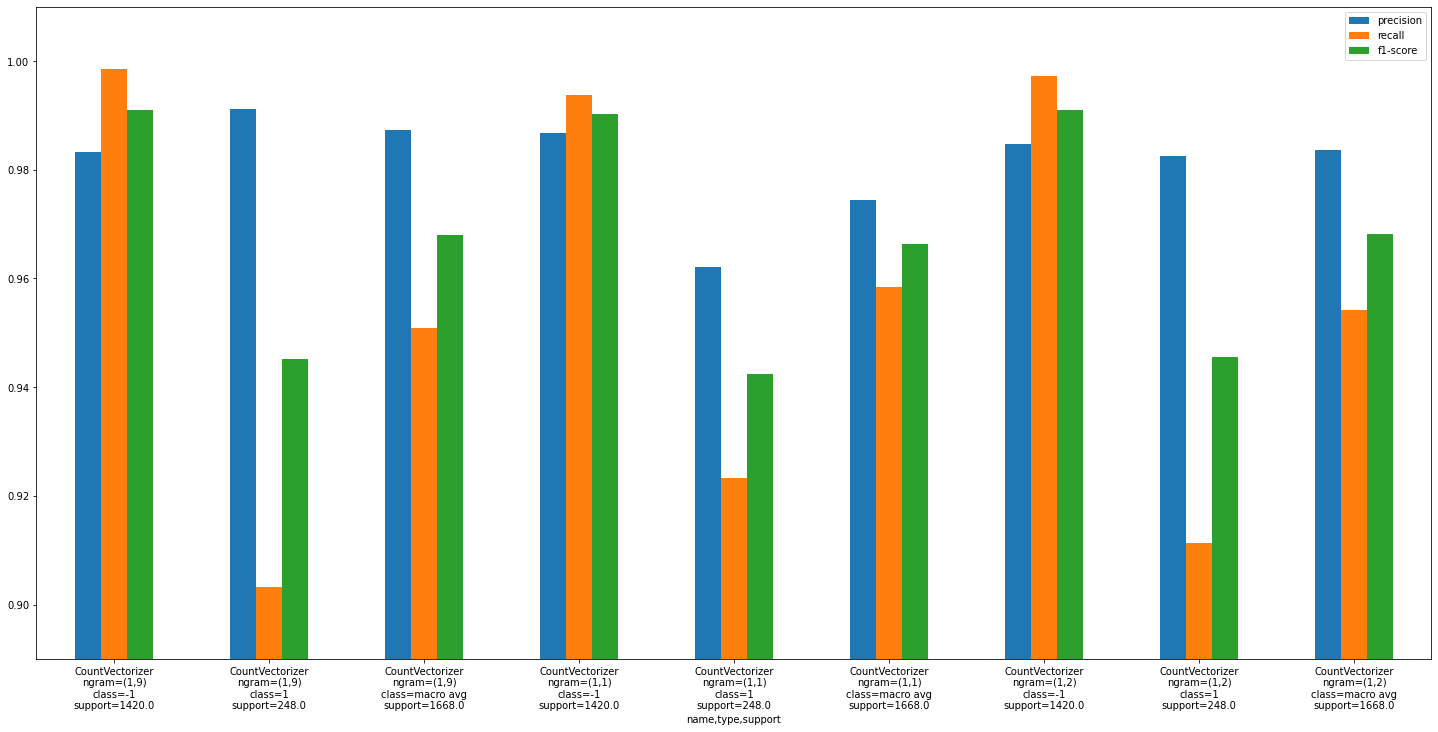

In [ ]:
# Визуализация результатов 
ngram_plot = df_result_ngram_plot.plot.bar(rot=0, figsize=(25, 12), ylim=(0.89, 1.01))
ngram_set_xticks = ngram_plot.set_xticklabels(create_x_ticks(df_result_ngram_plot.index))

#### 2. TF-IDF

In [ ]:
tfidf_max_size = 6
df_result_tfidf = pd.DataFrame()
tfidf_ranges = [(i, j) for i in range(1, tfidf_max_size) for j in range(i, tfidf_max_size)]  # 15
tfidf_max_df = np.arange(0.05, 0.26, 0.05)  # 5
tfidf_min_df = np.arange(0.0, 0.0009, 0.0002)  # 5
tfidf_max_features = np.arange(2 * 10 ** 2, 2 * 10 ** 3 + 1, 2 * 10 ** 2)  # 10
for tfidf_range in tfidf_ranges:
    for max_df in tfidf_max_df:
        for min_df in tfidf_min_df:
            for max_features in tfidf_max_features:
                # Векторизация
                tfidf_vectorizer = TfidfVectorizer(ngram_range=tfidf_range, max_df=max_df, min_df=min_df,
                                                    max_features=max_features)
                try:
                    x_train_tfidf = tfidf_vectorizer.fit_transform(x_train)
                except ValueError as _:
                    continue

                x_test_tfidf = tfidf_vectorizer.transform(x_test)
                v_name = f"{tfidf_vectorizer.__class__.__name__} ngram=({tfidf_range[0]},{tfidf_range[1]}) " \
                            f"max_df={max_df} min_df={min_df} max_features={max_features}"

                # Обучение
                model.fit(x_train_tfidf, y_train)

                # Тестирование
                y_pred_tfidf = model.predict(x_test_tfidf)
                report_tfidf = classification_report(y_test, y_pred_tfidf, output_dict=True)
                report_tfidf.update({"accuracy": {
                    "precision": None,
                    "recall": None,
                    "f1-score": report_tfidf["accuracy"],
                    "support": report_tfidf["macro avg"]["support"]}})

                # Оценка результатов
                result_tfidf = pd.DataFrame(report_tfidf).T
                result_tfidf.reset_index(level=0, inplace=True)
                result_tfidf = result_tfidf.rename(columns={"index": "type"})
                result_tfidf["name"] = v_name
                result_tfidf.set_index(["name", "type", "support"], inplace=True)
                df_result_tfidf = pd.concat([df_result_tfidf, result_tfidf])

In [ ]:
# Составление общей таблицы результатов
df_result_tfidf

precision  \
name                                                                    type         support              
TfidfVectorizer ngram=(1,1) max_df=0.05 min_df=0.0 max_features=200     -1           1420.0    0.955315   
                                                                        1            248.0     0.952880   
                                                                        accuracy     1668.0         NaN   
                                                                        macro avg    1668.0    0.954097   
                                                                        weighted avg 1668.0    0.954953   
...                                                                                                 ...   
TfidfVectorizer ngram=(5,5) max_df=0.25 min_df=0.0008 max_features=2000 -1           1420.0    0.853879   
                                                                        1            248.0     1.000000   
                                                                        accuracy     1668.0         NaN   
                                                                        macro avg    1668.0    0.926939   
                                                                        weighted avg 1668.0    0.875604   

                                                                                                recall  \
name                                                                    type         support             
TfidfVectorizer ngram=(1,1) max_df=0.05 min_df=0.0 max_features=200     -1           1420.0   0.993662   
                                                                        1            248.0    0.733871   
                                                                        accuracy     1668.0        NaN   
                                                                        macro avg    1668.0   0.863766   
                                                                        weighted avg 1668.0   0.955036   
...                                                                                                ...   
TfidfVectorizer ngram=(5,5) max_df=0.25 min_df=0.0008 max_features=2000 -1           1420.0   1.000000   
                                                                        1            248.0    0.020161   
                                                                        accuracy     1668.0        NaN   
                                                                        macro avg    1668.0   0.510081   
                                                                        weighted avg 1668.0   0.854317   

                                                                                              f1-score  
name                                                                    type         support            
TfidfVectorizer ngram=(1,1) max_df=0.05 min_df=0.0 max_features=200     -1           1420.0   0.974111  
                                                                        1            248.0    0.829157  
                                                                        accuracy     1668.0   0.955036  
                                                                        macro avg    1668.0   0.901634  
                                                                        weighted avg 1668.0   0.952559  
...                                                                                                ...  
TfidfVectorizer ngram=(5,5) max_df=0.25 min_df=0.0008 max_features=2000 -1           1420.0   0.921181  
                                                                        1            248.0    0.039526  
                                                                        accuracy     1668.0   0.854317  
                                                                        macro avg    1668.0   0.480353  
                                                               

Найдём те параметры векторайзера, при которых были получены лучшие показатели оценки качества по каждой из метрик и отобразим их на графике для каждого из классов (отбор производился по macro avg, т.к это наиболее объективно в случае несбалансированной выборки):

In [ ]:
df_result_tfidf_plot = pd.DataFrame()
for column in df_result_tfidf.columns:
    df_result_tfidf_avg = df_result_tfidf.loc[
        df_result_tfidf.index.get_level_values("type") == "macro avg"]
    df_result_tfidf_classes = df_result_tfidf.loc[
        df_result_tfidf.index.get_level_values("type").isin(["-1", "1", "macro avg"])]
    index_max = df_result_tfidf_avg[column].idxmax()
    df_result_tfidf_plot = pd.concat(
        [df_result_tfidf_plot, df_result_tfidf_classes.loc[[index_max[0]]]])
    
df_result_tfidf_plot.drop_duplicates(inplace=True)
df_result_tfidf_plot

precision  \
name                                                                                   type      support              
TfidfVectorizer ngram=(1,2) max_df=0.15000000000000002 min_df=0.0004 max_features=1200 -1        1420.0    0.977946   
                                                                                       1         248.0     0.995392   
                                                                                       macro avg 1668.0    0.986669   

                                                                                                            recall  \
name                                                                                   type      support             
TfidfVectorizer ngram=(1,2) max_df=0.15000000000000002 min_df=0.0004 max_features=1200 -1        1420.0   0.999296   
                                                                                       1         248.0    0.870968   
                                                                                       macro avg 1668.0   0.935132   

                                                                                                          f1-score  
name                                                                                   type      support            
TfidfVectorizer ngram=(1,2) max_df=0.15000000000000002 min_df=0.0004 max_features=1200 -1        1420.0   0.988506  
                                                                                       1         248.0    0.929032  
                                                                                       macro avg 1668.0   0.958769

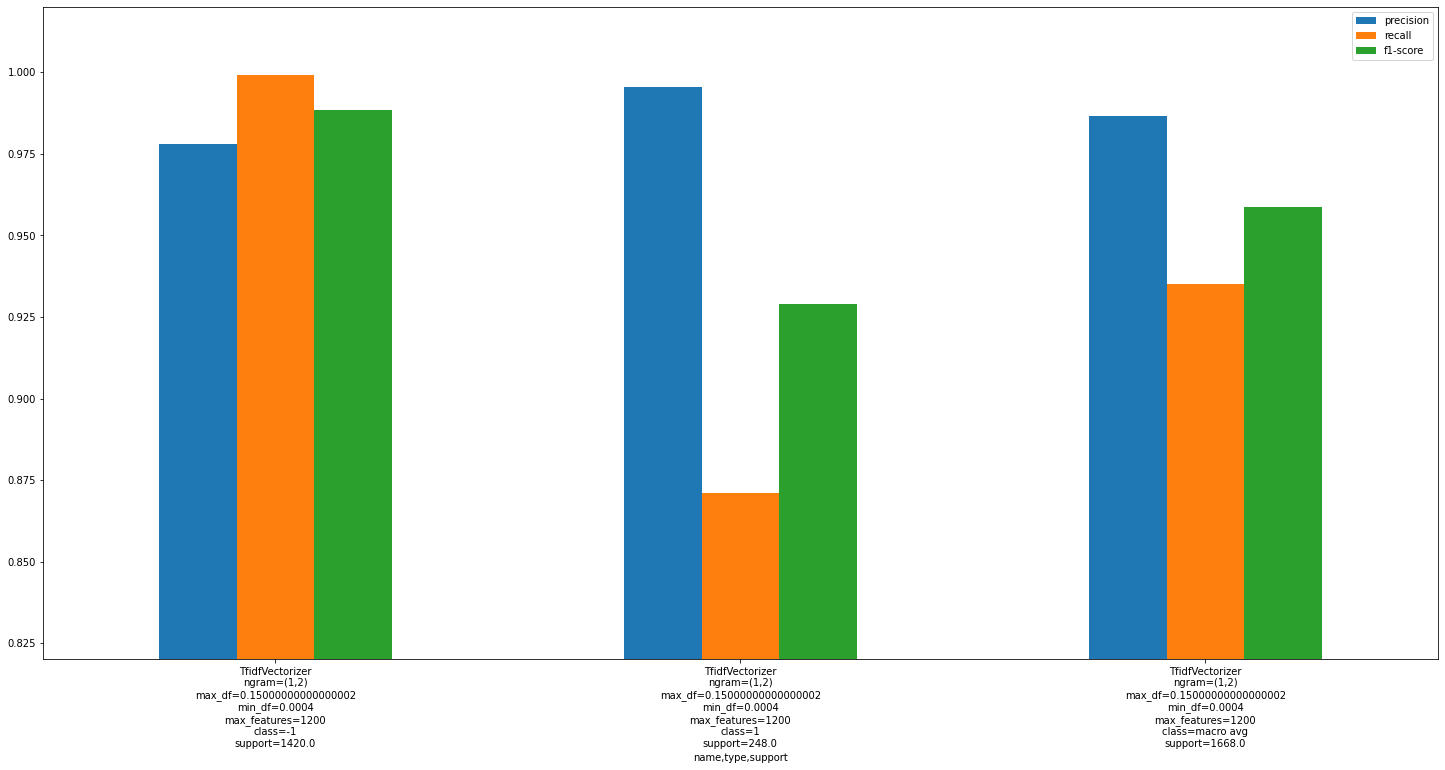

In [ ]:
# Визуализация результатов
tfidf_plot = df_result_tfidf_plot.plot.bar(rot=0, figsize=(25, 12), ylim=(0.82, 1.02))
tfidf_set_xticks = tfidf_plot.set_xticklabels(create_x_ticks(df_result_tfidf_plot.index))

#### 3. Символьные n-граммы

In [ ]:
char_ngram_max_size = 21
df_result_char_ngram = pd.DataFrame()
char_ngram_ranges = [(i, j) for i in range(1, char_ngram_max_size) for j in range(i, char_ngram_max_size)]
for char_ngram_range in char_ngram_ranges:
    # Векторизация
    char_ngram_vectorizer = CountVectorizer(analyzer="char", ngram_range=char_ngram_range)
    x_train_char_ngram = char_ngram_vectorizer.fit_transform(x_train)
    x_test_char_ngram = char_ngram_vectorizer.transform(x_test)
    v_name = f"Char{char_ngram_vectorizer.__class__.__name__} ngram=({char_ngram_range[0]},{char_ngram_range[1]})"

    # Обучение
    model.fit(x_train_char_ngram, y_train)

    # Тестирование
    y_pred_char_ngram = model.predict(x_test_char_ngram)
    report_char_ngram = classification_report(y_test, y_pred_char_ngram, output_dict=True)
    report_char_ngram.update({"accuracy": {
        "precision": None,
        "recall": None,
        "f1-score": report_char_ngram["accuracy"],
        "support": report_char_ngram["macro avg"]["support"]}})

    # Оценка результатов
    result_char_ngram = pd.DataFrame(report_char_ngram).T
    result_char_ngram.reset_index(level=0, inplace=True)
    result_char_ngram = result_char_ngram.rename(columns={"index": "type"})
    result_char_ngram["name"] = v_name
    result_char_ngram.set_index(["name", "type", "support"], inplace=True)
    df_result_char_ngram = pd.concat([df_result_char_ngram, result_char_ngram])

In [ ]:
# Составление общей таблицы результатов
df_result_char_ngram

precision    recall  \
name                              type         support                        
CharCountVectorizer ngram=(1,1)   -1           1420.0    0.973501  0.983099   
                                  1            248.0     0.897436  0.846774   
                                  accuracy     1668.0         NaN       NaN   
                                  macro avg    1668.0    0.935468  0.914936   
                                  weighted avg 1668.0    0.962191  0.962830   
...                                                           ...       ...   
CharCountVectorizer ngram=(20,20) -1           1420.0    0.944149  1.000000   
                                  1            248.0     1.000000  0.661290   
                                  accuracy     1668.0         NaN       NaN   
                                  macro avg    1668.0    0.972074  0.830645   
                                  weighted avg 1668.0    0.952453  0.949640   

                                                        f1-score  
name                              type         support            
CharCountVectorizer ngram=(1,1)   -1           1420.0   0.978276  
                                  1            248.0    0.871369  
                                  accuracy     1668.0   0.962830  
                                  macro avg    1668.0   0.924823  
                                  weighted avg 1668.0   0.962381  
...                                                          ...  
CharCountVectorizer ngram=(20,20) -1           1420.0   0.971272  
                                  1            248.0    0.796117  
                                  accuracy     1668.0   0.949640  
                                  macro avg    1668.0   0.883694  
                                  weighted avg 1668.0   0.945230  

[1050 rows x 3 columns]

Найдём те параметры векторайзера, при которых были получены лучшие показатели оценки качества по каждой из метрик и отобразим их на графике для каждого из классов (отбор производился по macro avg, т.к это наиболее объективно в случае несбалансированной выборки):

In [ ]:
df_result_char_ngram_plot = pd.DataFrame()
for column in df_result_char_ngram.columns:
    df_result_char_ngram_avg = df_result_char_ngram.loc[
        df_result_char_ngram.index.get_level_values("type") == "macro avg"]
    df_result_char_ngram_classes = df_result_char_ngram.loc[
        df_result_char_ngram.index.get_level_values("type").isin(["-1", "1", "macro avg"])]
    index_max = df_result_char_ngram_avg[column].idxmax()
    df_result_char_ngram_plot = pd.concat(
        [df_result_char_ngram_plot, df_result_char_ngram_classes.loc[[index_max[0]]]])
    
df_result_char_ngram_plot.drop_duplicates(inplace=True)
df_result_char_ngram_plot

precision    recall  \
name                             type      support                        
CharCountVectorizer ngram=(3,16) -1        1420.0    0.982663  0.997887   
                                 1         248.0     0.986726  0.899194   
                                 macro avg 1668.0    0.984694  0.948540   
CharCountVectorizer ngram=(6,6)  -1        1420.0    0.989422  0.988028   
                                 1         248.0     0.932000  0.939516   
                                 macro avg 1668.0    0.960711  0.963772   
CharCountVectorizer ngram=(3,12) -1        1420.0    0.984017  0.997183   
                                 1         248.0     0.982533  0.907258   
                                 macro avg 1668.0    0.983275  0.952221   

                                                    f1-score  
name                             type      support            
CharCountVectorizer ngram=(3,16) -1        1420.0   0.990217  
                                 1         248.0    0.940928  
                                 macro avg 1668.0   0.965572  
CharCountVectorizer ngram=(6,6)  -1        1420.0   0.988724  
                                 1         248.0    0.935743  
                                 macro avg 1668.0   0.962234  
CharCountVectorizer ngram=(3,12) -1        1420.0   0.990556  
                                 1         248.0    0.943396  
                                 macro avg 1668.0   0.966976

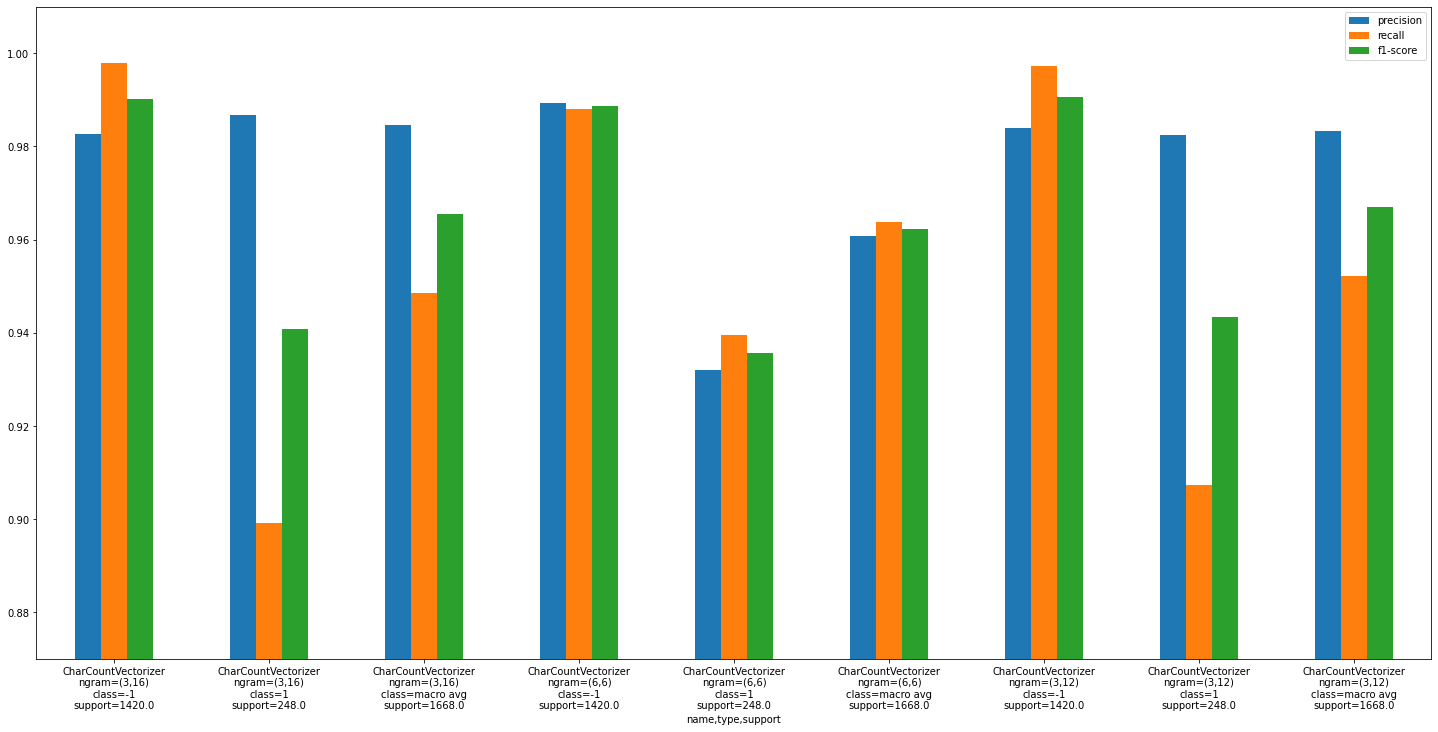

In [ ]:
# Визуализация результатов
char_ngram_plot = df_result_char_ngram_plot.plot.bar(rot=0, figsize=(25, 12), ylim=(0.87, 1.01))
char_ngram_set_xticks = char_ngram_plot.set_xticklabels(create_x_ticks(df_result_char_ngram_plot.index))

#### 4. Лучшие векторайзеры

In [ ]:
frames = [df_result_ngram_plot, df_result_tfidf_plot, df_result_char_ngram_plot]
df_result_vectorizers = pd.concat(frames)
df_result_vectorizers

precision  \
name                                                                                   type      support              
CountVectorizer ngram=(1,9)                                                            -1        1420.0    0.983356   
                                                                                       1         248.0     0.991150   
                                                                                       macro avg 1668.0    0.987253   
CountVectorizer ngram=(1,1)                                                            -1        1420.0    0.986713   
                                                                                       1         248.0     0.962185   
                                                                                       macro avg 1668.0    0.974449   
CountVectorizer ngram=(1,2)                                                            -1        1420.0    0.984701   
                                                                                       1         248.0     0.982609   
                                                                                       macro avg 1668.0    0.983655   
TfidfVectorizer ngram=(1,2) max_df=0.15000000000000002 min_df=0.0004 max_features=1200 -1        1420.0    0.977946   
                                                                                       1         248.0     0.995392   
                                                                                       macro avg 1668.0    0.986669   
CharCountVectorizer ngram=(3,16)                                                       -1        1420.0    0.982663   
                                                                                       1         248.0     0.986726   
                                                                                       macro avg 1668.0    0.984694   
CharCountVectorizer ngram=(6,6)                                                        -1        1420.0    0.989422   
                                                                                       1         248.0     0.932000   
                                                                                       macro avg 1668.0    0.960711   
CharCountVectorizer ngram=(3,12)                                                       -1        1420.0    0.984017   
                                                                                       1         248.0     0.982533   
                                                                                       macro avg 1668.0    0.983275   

                                                                                                            recall  \
name                                                                                   type      support             
CountVectorizer ngram=(1,9)                                                            -1        1420.0   0.998592   
                                                                                       1         248.0    0.903226   
                                                                                       macro avg 1668.0   0.950909   
CountVectorizer ngram=(1,1)                                                            -1        1420.0   0.993662   
                                                                                       1         248.0    0.923387   
                                                                                       macro avg 1668.0   0.958525   
CountVectorizer ngram=(1,2)                                                            -1        1420.0   0.997183   
                                                                                       1         248.0    0.911290   
                                                                                       macro avg 1668.0   0.954237   
TfidfVectorizer ngram=(1,2) max_df=0.15000000000000002 min_df=0.0004 m

##### Precision

In [ ]:
df_precision_best = df_result_vectorizers.loc[df_result_vectorizers.index.get_level_values("type") == "macro avg"]
index_max_precision = df_precision_best.precision.idxmax()
df_result_vectorizers.loc[[index_max_precision[0]]]

precision    recall  f1-score
name                        type      support                               
CountVectorizer ngram=(1,9) -1        1420.0    0.983356  0.998592  0.990915
                            1         248.0     0.991150  0.903226  0.945148
                            macro avg 1668.0    0.987253  0.950909  0.968032

##### Recall

In [ ]:
df_recall_best = df_result_vectorizers.loc[df_result_vectorizers.index.get_level_values("type") == "macro avg"]
index_max_recall = df_recall_best.recall.idxmax()
df_result_vectorizers.loc[[index_max_recall[0]]]

precision    recall  \
name                            type      support                        
CharCountVectorizer ngram=(6,6) -1        1420.0    0.989422  0.988028   
                                1         248.0     0.932000  0.939516   
                                macro avg 1668.0    0.960711  0.963772   

                                                   f1-score  
name                            type      support            
CharCountVectorizer ngram=(6,6) -1        1420.0   0.988724  
                                1         248.0    0.935743  
                                macro avg 1668.0   0.962234

##### F1 Score

In [ ]:
df_f1_score_best = df_result_vectorizers.loc[df_result_vectorizers.index.get_level_values("type") == "macro avg"]
index_max_f1_score = df_f1_score_best["f1-score"].idxmax()
df_result_vectorizers.loc[[index_max_recall[0]]]

precision    recall  \
name                            type      support                        
CharCountVectorizer ngram=(6,6) -1        1420.0    0.989422  0.988028   
                                1         248.0     0.932000  0.939516   
                                macro avg 1668.0    0.960711  0.963772   

                                                   f1-score  
name                            type      support            
CharCountVectorizer ngram=(6,6) -1        1420.0   0.988724  
                                1         248.0    0.935743  
                                macro avg 1668.0   0.962234

### Вывод:

Самым лучшим векторайзером по показателям f1, и recall является **Char Count Vectorizer** с параметром n_gram равным (6, 6). По критерию precision хорошей точности удалось добиться **Count Vectorizer** с параметром n_gram равным (1, 9). Наихудший результат в разрезе данного тестирования продемонстрировал **TF-IDF Vectorizer**, хотя его оценка отличается не столь значительно, так что при более удачных параметрах, вероятно, её можно было бы сравнять с вышеописанными методами векторизации.

## Задание 5.2 Регулярные выражения

Регулярные выражения - способ поиска и анализа строк. Например, можно понять, какие даты в наборе строк представлены в формате DD/MM/YYYY, а какие - в других форматах. 

Или бывает, например, что перед работой с текстом, надо почистить его от своеобразного мусора: упоминаний пользователей, url и так далее.

Навык полезный, давайте в нём тоже потренируемся.

Для работы с регулярными выражениями есть библиотека **re**

In [ ]:
import re

В регулярных выражениях, кроме привычных символов-букв, есть специальные символы:
* **?а** - ноль или один символ **а**
* **+а** - один или более символов **а**
* **\*а** - ноль или более символов **а** (не путать с +)
* **.** - любое количество любого символа

Пример:
Выражению \*a?b. соответствуют последовательности a, ab, abc, aa, aac НО НЕ abb!

Рассмотрим подробно несколько наиболее полезных функций:

### findall
возвращает список всех найденных непересекающихся совпадений.

Регулярное выражение **ab+c.**: 
* **a** - просто символ **a**
* **b+** - один или более символов **b**
* **c** - просто символ **c**
* **.** - любой символ


In [ ]:
result = re.findall('ab+c.', 'abcdefghijkabcabcxabc') 
print(result)

['abcd', 'abca']


Вопрос на внимательность: почему нет abcx?

Оно пересекается с "abca"

**Задание**: вернуть список первых двух букв каждого слова в строке, состоящей из нескольких слов.

In [ ]:
string = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et " \
         "dolore magna aliqua."

result = re.findall(r"\b[a-zA-z]{2}", string)
print(result)

['Lo', 'ip', 'do', 'si', 'am', 'co', 'ad', 'el', 'se', 'do', 'ei', 'te', 'in', 'ut', 'la', 'et', 'do', 'ma', 'al']


### split
разделяет строку по заданному шаблону


In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie') 
print(result)

['itsy', ' bitsy', ' teenie', ' weenie']


можно указать максимальное количество разбиений

In [ ]:
result = re.split(',', 'itsy, bitsy, teenie, weenie', maxsplit=2) 
print(result)

['itsy', ' bitsy', ' teenie, weenie']


**Задание**: разбейте строку, состоящую из нескольких предложений, по точкам, но не более чем на 3 предложения.

In [ ]:
string = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et " \
         "dolore magna aliqua. Proin sagittis nisl rhoncus mattis rhoncus. Id nibh tortor id aliquet. Pulvinar " \
         "elementum integer enim neque volutpat. Lobortis mattis aliquam faucibus purus in. Feugiat nisl pretium " \
         "fusce id velit ut tortor."

result = re.split(r"\.", string, maxsplit=2)
print("\n".join(result))

Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et dolore magna aliqua
 Proin sagittis nisl rhoncus mattis rhoncus
 Id nibh tortor id aliquet. Pulvinar elementum integer enim neque volutpat. Lobortis mattis aliquam faucibus purus in. Feugiat nisl pretium fusce id velit ut tortor.


### sub
ищет шаблон в строке и заменяет все совпадения на указанную подстроку

параметры: (pattern, repl, string)

In [ ]:
result = re.sub('a', 'b', 'abcabc')
print (result)

bbcbbc


**Задание**: напишите регулярное выражение, которое позволит заменить все цифры в строке на "DIG".

In [ ]:
string = "Lorem4 ipsum dolor 2 sit amet, consectetur adipiscing elit, se8d do eiusmod tempor incididunt ut " \
         "7labore et dolore ma1gna aliqua. Sed a6rcu non odio euism99od lacinia at."

result = re.sub(r"[0-9]", "DIG", string)
print(result)

LoremDIG ipsum dolor DIG sit amet, consectetur adipiscing elit, seDIGd do eiusmod tempor incididunt ut DIGlabore et dolore maDIGgna aliqua. Sed aDIGrcu non odio euismDIGDIGod lacinia at.


**Задание**: напишите  регулярное выражение, которое позволит убрать url из строки.

In [ ]:
string = "Google Drive: https://drive.google.com Youtube: https://www.youtube.com/watch?v=dQw4w9WgXcQ " \
         "Facebook: https://www.facebook.com Instagram: http://www.instagram.com"

result = re.sub(r"(https?://)?(www\.)?([.\w]+)\.([a-z]{2,3})([/?=&\w]+)?", r"", string)
print(result)

Google Drive:  Youtube:  Facebook:  Instagram: 


### compile
компилирует регулярное выражение в отдельный объект

In [ ]:
# Пример: построение списка всех слов строки:
prog = re.compile('[А-Яа-яё\-]+')
prog.findall("Слова? Да, больше, ещё больше слов! Что-то ещё.")

['Слова', 'Да', 'больше', 'ещё', 'больше', 'слов', 'Что-то', 'ещё']

**Задание**: для выбранной строки постройте список слов, которые длиннее трех символов.

In [ ]:
string = "Lorem ipsum dolor sit amet, consectetur adipiscing elit, sed do eiusmod tempor incididunt ut labore et " \
         "dolore magna aliqua."

regex = re.compile(r"\b\w{4,}")
result = regex.findall(string)
print(result)

['Lorem', 'ipsum', 'dolor', 'amet', 'consectetur', 'adipiscing', 'elit', 'eiusmod', 'tempor', 'incididunt', 'labore', 'dolore', 'magna', 'aliqua']


**Задание**: вернуть список доменов (@gmail.com) из списка адресов электронной почты:

```
abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz
```

In [ ]:
string = "abc.test@gmail.com, xyz@test.in, test.first@analyticsvidhya.com, first.test@rest.biz"

regex = re.compile(r"@[a-z]+\.[a-z]{2,3}")
result = regex.findall(string)
print(result)

['@gmail.com', '@test.in', '@analyticsvidhya.com', '@rest.biz']
